# HHCART(D) on the Hamarat et al. 2013 Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from ema_workbench import load_results
from ema_workbench.analysis import RuleInductionType
from ema_workbench.analysis.feature_scoring import get_ex_feature_scores

from HHCART_SD import HHCartD, load_model
from plot_outcomes_lineplot_gaussian import plot_fraction_renewables
from clean_hamarat import clean_results
from src.config.paths import HAMARAT_DATA_DIR

## Load and Clean the Data

In [2]:
# Load results
experiments, outcomes = load_results(HAMARAT_DATA_DIR / "10000_lhs.tar.gz")

# Clean data → get X and y
X, y_continuous = clean_results(experiments, outcomes)

 ## Plot the Data

Figure saved: renewables_over_time_0_6_threshold.pdf


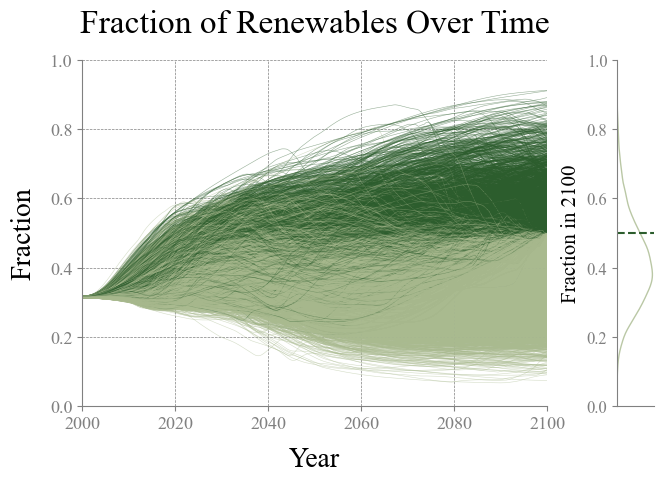


At threshold the threshold of 50.0% renewables by 2100:
22.8% of cases exceed threshold (2281 of 10000), 77.2% of cases below threshold (7719 of 10000)


In [3]:
plot_fraction_renewables(outcomes, threshold=0.5, save_path="renewables_over_time_0_6_threshold.pdf")

## Set Binary Threshold for y

In [4]:
threshold_value = 0.5  # for example
y = (y_continuous > threshold_value).astype(int)

In [5]:
# Convert categorical variables to dummy variables
categorical_cols = [col for col in X.columns if str(X[col].dtype) == 'category']
X_dummy = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=float)

print(f"\nChanged categorical variables to dummy variables making the experiments Dataframe gain {X_dummy.shape[1]-X.shape[1]} columns.")


Changed categorical variables to dummy variables making the experiments Dataframe gain 22 columns.


In [6]:
# # Drop SWITCH columns, as they are not needed for the analysis
# switch_cols = [col for col in X_dummy.columns if col.startswith("SWITCH")]
# X_encoded = X_dummy.drop(columns=switch_cols)

## Applying HHCART(D)

In [ ]:
# Set tree parameters
max_depth = 8
min_purity = 0.95
mass_min = 0.05

# Instantiate HHCART, build and save tree
hh = HHCartD(X_dummy, y, min_purity=min_purity, mass_min=mass_min, max_depth=max_depth)
hh.build_tree(f"hamarat_depth_{max_depth}_pur_{str(min_purity).replace('.', '_')}_mass_{str(mass_min).replace('.', '_')}")

[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by minimum mass constraint: 31 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes: 46it [52:28, 18.72s/it]                          

In [ ]:
hh = load_model("barbell_2d_label_noise_005_max_depth_8_pur_0_9_mass_0_05")
hh.select(depth=3)
hh.inspect()

In [ ]:
hh.plot_tree_structure(depth=6, save=True)

In [ ]:
hh.plot_metrics_vs_structure(save=True)

In [ ]:
hh.plot_metrics_vs_structure(save=True, x_axis="class1_leaf_count")

In [ ]:
hh.plot_tradeoff_path(save=True)

In [ ]:
hh.plot_tradeoff_path(save=True, color_by="class1_leaf_count")

In [ ]:
hh.plot_node_size_distribution(save=True)

In [ ]:
hh.plot_splits_2d_grid(save=True)

In [ ]:
hh.plot_splits_2d_overlay(depth=6, save=True)

In [ ]:
hh.plot_regions_2d_grid(save=True)

## Applying Extra Trees Feature Scoring to Determine Features of Interest

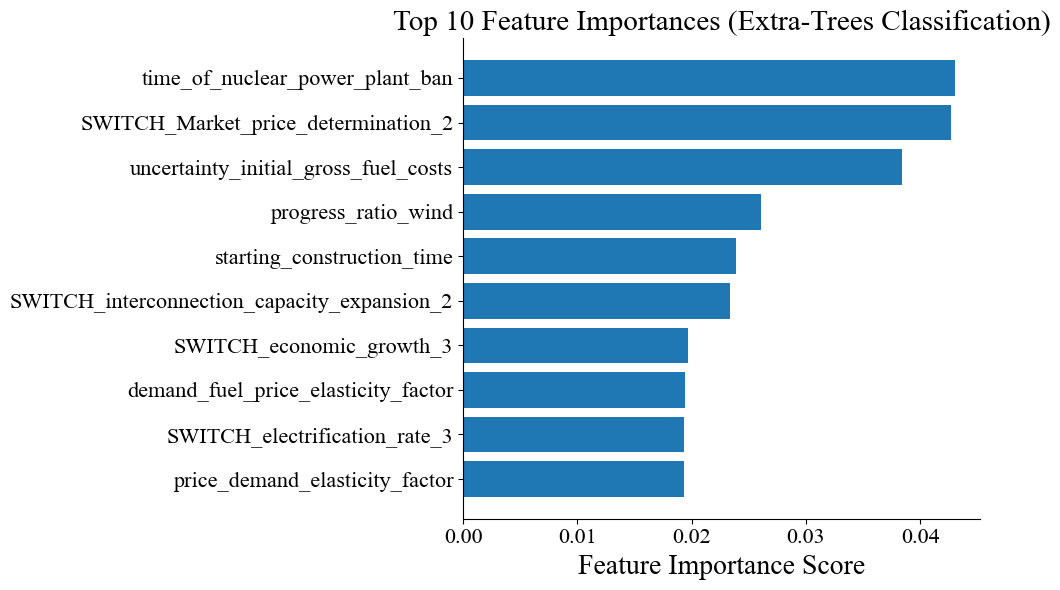

In [8]:
feature_scores_class, model_class = get_ex_feature_scores(
    x=X_dummy,
    y=y,
    mode=RuleInductionType.CLASSIFICATION,
    nr_trees=250,
    max_features=None,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    oob_score=True,
    random_state=42
)

top_n = 10
top_features_class = feature_scores_class.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features_class.index, top_features_class.iloc[:, 0])  # assuming first column is the score
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Feature Importance (Extra-Trees Classification)')
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

In [ ]:
# Set tree parameters
max_depth = 8
min_purity = 0.90
mass_min = 0.05

# Instantiate HHCART, build and save tree
hh = HHCartD(X, y, min_purity=min_purity, mass_min=mass_min, max_depth=max_depth)
hh.build_tree(
    f"hamarat_depth_{max_depth}_pur_{str(min_purity).replace('.', '_')}_mass_{str(mass_min).replace('.', '_')}")

In [ ]:
hh = load_model("barbell_2d_label_noise_005_max_depth_8_pur_0_9_mass_0_05")
hh.select(depth=3)
hh.inspect()

In [ ]:
hh.plot_tree_structure(depth=6, save=True)

In [ ]:
hh.plot_metrics_vs_structure(save=True)

In [ ]:
hh.plot_metrics_vs_structure(save=True, x_axis="class1_leaf_count")

In [ ]:
hh.plot_tradeoff_path(save=True)

In [ ]:
hh.plot_tradeoff_path(save=True, color_by="class1_leaf_count")

In [ ]:
hh.plot_node_size_distribution(save=True)

In [ ]:
hh.plot_splits_2d_grid(save=True)

In [ ]:
hh.plot_splits_2d_overlay(depth=6, save=True)

In [ ]:
hh.plot_regions_2d_grid(save=True)